In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib
import pandas as pd
matplotlib.use('agg')
import matplotlib.pyplot as plt
import random
import re

from sklearn import model_selection

/home/asr/tensorflow-cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/asr/tensorflow-cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from stop_words import get_stop_words

## CORPORA: Specific vs Generic

In [3]:
%%time

# NOTE: Put in corpus_2 the largest corpus

num_lines_corpus_spec_1  = sum(1 for line in open('/home/asr/Data/classif_task/dev_data/calendar/jsgf/jsgf-calendar-1'))
num_lines_corpus_spec_2  = sum(1 for line in open('/home/asr/Data/classif_task/dev_data/calendar/subtitles/subtitle-cleaned-keyfiltered'))
#num_lines_corpus_2  = sum(1 for line in open('/home/asr/Data/classif_task/dev_data/generic/paisa-cleaned-v8-0'))
num_lines_corpus_gen_2  = sum(1 for line in open('/home/asr/Data/classif_task/dev_data/generic-maxlength16/generic-corpus-maxlength16-v1'))

ratio_cal = num_lines_corpus_spec_1 / float(num_lines_corpus_spec_2)
ratio = (num_lines_corpus_spec_1 + num_lines_corpus_spec_2) / float(num_lines_corpus_gen_2) #if num_lines_corpus_1 < num_lines_corpus_1 else num_lines_corpus_2 / float(num_lines_corpus_1)
print('Corpus_cal_1: %d, Corpus_cal_2: %d, Corpus_2: %d, Ratio: %0.3f' %(num_lines_corpus_spec_1, num_lines_corpus_spec_2, num_lines_corpus_gen_2, ratio)) 

Corpus_cal_1: 99412, Corpus_cal_2: 266442, Corpus_2: 10111563, Ratio: 0.036
CPU times: user 4.93 s, sys: 2.08 s, total: 7.01 s
Wall time: 12.8 s


In [4]:
ratio_cal = num_lines_corpus_spec_1 / float(num_lines_corpus_spec_2)
ratio_cal

0.37310934462284473

## CORPORA: Specific_1 vs Specific_2

In [26]:
%%time

# NOTE: Put in corpus_2 the largest corpus

# num_lines_corpus_1  = sum(1 for line in open('/home/asr/Data/classif_task/dev_data/calendar/jsgf-calendar-1'))
# num_lines_corpus_2  = sum(1 for line in open('/home/asr/Data/classif_task/dev_data/generic/paisa-cleaned-v8-0'))

num_lines_corpus_1 = 0
num_lines_corpus_2 = 0

for num in [1,2,3]:
    num_lines_corpus_1 += sum(1 for line in open('/home/asr/Data/classif_task/jsgf_data/email/email_' + str(num) + '.expand'))
    num_lines_corpus_2 += sum(1 for line in open('/home/asr/Data/classif_task/jsgf_data/reminder/reminder_' + str(num) + '.expand'))


ratio = num_lines_corpus_1 / float(num_lines_corpus_2) #if num_lines_corpus_1 < num_lines_corpus_1 else num_lines_corpus_2 / float(num_lines_corpus_1)
print('Corpus_1: %d, Corpus_2: %d, Ratio: %0.3f' %(num_lines_corpus_1, num_lines_corpus_2, ratio)) 

Corpus_1: 893346, Corpus_2: 950421, Ratio: 0.940
CPU times: user 459 ms, sys: 50.3 ms, total: 510 ms
Wall time: 946 ms


## Building the Data-Frame (Balanced)

In [18]:
ratio = (num_lines_corpus_cal_1 + ratio_cal*num_lines_corpus_cal_2) / float(num_lines_corpus_2)

In [6]:
def load_dataset(directory_1, directory_2, directory_3):
    # NOTE: Put in directory_2 the largest corpus
    data = {}
    data["sentence"] = []
    data["class"] = []
    l1 = 0
    for file_path in os.listdir(directory_1):
        with tf.gfile.GFile(os.path.join(directory_1 , file_path), "rb") as f:
                # strip() removes white spaces before and after the string
                # decode() converst a byte object ('b) in a python3 string
                list_of_sentences = [s.strip().decode() for s in f.readlines()]
                num_rows_1 = len(list_of_sentences)
                for i in range(num_rows_1):
                    data["sentence"].append(list_of_sentences[i])
                    data["class"].append(1)
    
    for file_path in os.listdir(directory_2):
        with tf.gfile.GFile(os.path.join(directory_2 , file_path), "rb") as f:
                # strip() removes white spaces before and after the string
                # decode() converst a byte object ('b) in a python3 string
                list_of_sentences = [s.strip().decode() for s in f.readlines() if np.random.random() <= ratio_cal]
                num_rows_1 = len(list_of_sentences)
                for i in range(num_rows_1):
                    data["sentence"].append(list_of_sentences[i])
                    data["class"].append(1)
    
    for file_path in os.listdir(directory_3):
        with tf.gfile.GFile(os.path.join(directory_3, file_path), "rb") as f:
            # Balancing the dataset
            list_of_sentences = [s.strip().decode() for s in f.readlines() if np.random.random() <= ratio]
            for i in range(len(list_of_sentences)):
                data["sentence"].append(list_of_sentences[i])
                data["class"].append(0)
    return pd.DataFrame.from_dict(data)




In [7]:
%%time
directory_1 = '/home/asr/Data/classif_task/dev_data/calendar/jsgf/'
directory_2 = '/home/asr/Data/classif_task/dev_data/calendar/subtitles/'
directory_3 = '/home/asr/Data/classif_task/dev_data/generic-maxlength16/'

#directory_1 = '/home/asr/Data/classif_task/jsgf_data/email/'
#directory_2 = '/home/asr/Data/classif_task/jsgf_data/reminder/'

dataset_df = load_dataset(directory_1, directory_2, directory_3)

CPU times: user 34.6 s, sys: 2.46 s, total: 37.1 s
Wall time: 37.4 s


In [8]:
# Check Balanced
dataset_df.groupby('class').count()

,sentence
class,
0,366146
1,198790


In [9]:
# Print some samples
for i in range(10):
    print(dataset_df.iloc[i]['sentence'])
    print(dataset_df.iloc[-i -1]['sentence'])

modifica attività
hanno mantenuto stabili al 5 per cento le loro quote sul mercato mondiale
fai partire calendario
venale e simoniaco alle concessioni del pontefice per cui i poveri erano spietatamente esclusi mentre i
mostrami la vista giorno nel calendario
protestanti che alterarono abilmente la fraseologia e le cifre di modo da fornire un aspetto esclusivamente
vorrei aprire calendario e visualizza settimana
ovvero comportarsi in modo diverso
mostra applicazione agenda per favore e visualizza settimana
di almeno quattro f15 con il lancio di ben otto aim7m che ebbero così una notevole
vorrei vedere la vista giorno nell'applicazione calendario per piacere
conobbe il suo maggior splendore bastano i numeri a descriverlo 8 campionati spagnoli 5 coppe dei
puoi aprire vista settimana nell'app calendario per favore ?
ma dwyane wade ebbe una delle sue migliori stagioni in carriera segnando più dipunti e distribuendo
imposta notifiche nelle impostazioni dell'agenda
ma dura poco infatti con la

In [10]:
dataset_df.head(5)

,sentence,class
0,modifica attività,1
1,fai partire calendario,1
2,mostrami la vista giorno nel calendario,1
3,vorrei aprire calendario e visualizza settimana,1
4,mostra applicazione agenda per favore e visual...,1


In [11]:
dataset_df.tail(5)

,sentence,class
564931,di almeno quattro f15 con il lancio di ben ott...,0
564932,ovvero comportarsi in modo diverso,0
564933,protestanti che alterarono abilmente la fraseo...,0
564934,venale e simoniaco alle concessioni del pontef...,0
564935,hanno mantenuto stabili al 5 per cento le loro...,0


### Statistics about the dataset

In [12]:
# Counting number of words and mean
dataset_df.astype('str').applymap(lambda x: str(x).count(' ') + 1).mean()

sentence    11.39391
class        1.00000
dtype: float64

In [13]:
# Max length sentence
dataset_df.astype('str').applymap(lambda x: str(x).count(' ') + 1).max()

sentence    26
class        1
dtype: int64

In [14]:
# Max length sentence
dataset_df.astype('str').applymap(lambda x: str(x).count(' ') + 1).std()

sentence    4.402611
class       0.000000
dtype: float64

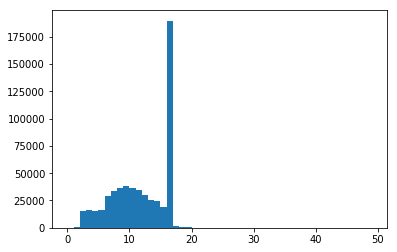

In [15]:
# Histogram of the lengths
%matplotlib inline

length_sentence = dataset_df.astype('str').applymap(lambda x: str(x).count(' ') + 1)
plt.hist(length_sentence['sentence'],bins=range(50))
plt.show()

### Shuffle the Dataset

In [16]:

index = [i for i in range(dataset_df.shape[0])]
random.shuffle(index)
dataset = dataset_df.set_index([index]).sort_index()

dataset.head(10)

,sentence,class
0,non avevo legami di ambiente non avevo impegni...,0
1,un nuovo episodio di grey s anatomy la settima...,1
2,casata di leonenepote,0
3,l ho pedinato per una settimana,1
4,assegnato al file per cui il processo dispone ...,0
5,in maniera obiettiva sia i pareri positivi sia...,0
6,sempre limitato sulla seconda e ciò portò ad u...,0
7,diventa collaboratore e redattore della rivist...,0
8,fu onorato neldel titolo di vilas professore r...,0
9,già trenta anni prima merenptah aveva sconfitt...,0


In [17]:
#dataset.to_csv('/home/asr/Data/classif_task/dev_data/dataset_blc.txt', sep='\t')

In [18]:
exclude1 = ['\t', '"', '?'] # list
exclude2 = ["'", "  ", "   ", "    ", "     "] # list

def clean_text(text):
    for c in exclude1:
        text=text.replace(c,'')
    for c in exclude2:
        text=text.replace(c, " ")
    return text.lower().strip()

sentence_processed = list(map(lambda text: clean_text(text), dataset['sentence'].values))

dataset['sentence'] = sentence_processed

dataset.head(20)

,sentence,class
0,non avevo legami di ambiente non avevo impegni...,0
1,un nuovo episodio di grey s anatomy la settima...,1
2,casata di leonenepote,0
3,l ho pedinato per una settimana,1
4,assegnato al file per cui il processo dispone ...,0
5,in maniera obiettiva sia i pareri positivi sia...,0
6,sempre limitato sulla seconda e ciò portò ad u...,0
7,diventa collaboratore e redattore della rivist...,0
8,fu onorato neldel titolo di vilas professore r...,0
9,già trenta anni prima merenptah aveva sconfitt...,0


In [30]:
for i in range(10):
    print(dataset.iloc[i]['sentence'])
    print(dataset.iloc[-i -1]['sentence'])

vorrei aggiungere appuntamento all agenda per ogni weekend
larmistizio di vignale
continuò fino alsalvo l interruzione della seconda guerra mondiale e fu progettata per un pubblico femminile borghese
parte di itachi sasuke visse solo con lo scopo di vendicare la famiglia e uccidere il
attribuzione errata
identificare tutto il gruppo
puoi creare un appuntamento alle cinque di mattina per favore
solo si rifiuta ma gli darà la mano in segno di rispetto
puoi creare un evento chiamato appuntamento con massimo alle sette e quarantacinque ogni primo weekend del mese
cioe un vero appuntamento che non fosse con un paziente o suo figlio
variabili superando talora anche i 300 metri
a poppa due tramogge per bombe torpedini da getto da 50 e 100 kg e due
poi piu tardi se ne andra e rimarremo solo io e te per l evento principale
grandi edifici il museo de logroňo con collezioni di sculture e quadri di varie epoche e
la membrana della maggior parte di questi batteri grampositivi è acido micolico con p

In [19]:
# Add a third column with the number of words in the sentence (we count them computing the number of spaces + 1)

# num_words_in_sentence = lambda x: str(x).count(' ') + 1

# dataset_tmp = dataset.assign(length=dataset['sentence'])
# dataset_tmp = dataset_tmp['length'].apply(num_words_in_sentence)
# dataset_with_length = dataset.assign(length=dataset_tmp)

# dataset_with_length.head(10)


In [20]:
LENGTH_COLUMN = False

if LENGTH_COLUMN == True:
    dataset = dataset_with_length


splitter =  model_selection.StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=19850610)

splits = list(splitter.split(X=dataset['sentence'], y=dataset['class']))
train_index = splits[0][0]
valid_index = splits[0][1]

train_df = dataset.loc[train_index,:]
print('Training-Set size: %d' %len(train_df))

valid_df = dataset.loc[valid_index,:]
print('Validation-Set size: %d' %len(valid_df))

Training-Set size: 451948
Validation-Set size: 112988


In [21]:
print("Training Set")
training_value_counts = train_df['class'].value_counts()
print(training_value_counts)
print("class 0 %: {}".format(round(training_value_counts[0]/len(train_df)*100,2)))
print("class 1 %: {}".format(round(training_value_counts[1]/len(train_df)*100,2)))
print("")
print("Validation Set")
validation_value_counts = valid_df['class'].value_counts()
print(validation_value_counts)
print("class 0 %: {}".format(round(validation_value_counts[0]/len(valid_df)*100,2)))
print("class 1 %: {}".format(round(validation_value_counts[1]/len(valid_df)*100,2)))

Training Set
0    292916
1    159032
Name: class, dtype: int64
class 0 %: 64.81
class 1 %: 35.19

Validation Set
0    73230
1    39758
Name: class, dtype: int64
class 0 %: 64.81
class 1 %: 35.19


In [26]:
if LENGTH_COLUMN == True:  
    train_df.to_csv(os.path.join(os.getcwd(), 'data-preparation/train-data-maxlength16-subtitles.tsv'), header=False, index=False, sep='\t')
    valid_df.to_csv(os.path.join(os.getcwd(), 'data-preparation/valid-data-maxlength16-subtitles.tsv'), header=False, index=False, sep='\t')
else: 
    train_df.to_csv(os.path.join(os.getcwd(), 'data-preparation/train-data-maxlength16-subtitles.tsv'), header=False, index=False, sep='\t')
    valid_df.to_csv(os.path.join(os.getcwd(), 'data-preparation/valid-data-maxlength16-subtitles.tsv'), header=False, index=False, sep='\t')

In [27]:
tt = pd.read_csv(os.path.join(os.getcwd(), 'data-preparation/train-data-maxlength16-subtitles.tsv'), sep='\t', names=['sentence','class'])
#tt['sentence'].iloc[0:20]

## Calculate Vocabulary and Save it

In [28]:
stop_words = get_stop_words('italian') + get_stop_words('english')

my_stop_words = ['puoi','posso','vediamo','guarda','vorrei','voglio','dici','fammi']
for my_word in my_stop_words:
    stop_words.append(my_word)

In [29]:
#stop_words

In [18]:
ww = ['criks', 'crjis3','cr456is', '45crist','1v','f4','16','l','9','5ffff56566778','cv']

falseIfDigit = lambda word: not bool((re.match('^(?=.*[0-9])', str(word))))

[w for w in ww if (falseIfDigit(w) or w.isdigit()) and (len(w) > 2 or w.isdigit()) ]

['criks', '16', '9']

In [35]:

# This function returns FALSE if there is a digit in the string (i.e '4mmm', 'm44m', 'llp4')
falseIfDigit = lambda word: not bool((re.match('^(?=.*[0-9])', str(word))))

def get_vocab():
    #allWords = []
    vocab = set()
    for text in train_df['sentence'].values:
        words = text.split(' ')
        # remove digits
        words_only = [w for w in words if not w.isdigit()]
        # exclude words shorter than 2, but not numbers. exclude words with numbers inside, i.e. '3cris', 'c45ris', 'cris23'
        words_ = [w for w in words_only if (falseIfDigit(w) or w.isdigit()) and (len(w) > 2 or w.isdigit()) ]
        #allWords = allWords + words_
        word_set = set(words_)
        vocab.update(word_set)
    
    #vocab.remove('')
    return list(vocab)#, allWords

def get_all_words():
    allWords = []
    cnt = 0
    for text in train_df['sentence'].values:
        words = text.split(' ')
        # remove digits
        words_only = [w for w in words if not w.isdigit()]
        # exclude words shorter than 2, but not numbers. exclude words with numbers inside, i.e. '3cris', 'c45ris', 'cris23'
        words_ = [w for w in words_only if (falseIfDigit(w) or w.isdigit()) and (len(w) > 2 or w.isdigit()) ]
        allWords = allWords + words_
        #word_set = set(words_)
        cnt += 1
        if cnt%10000==0:
            print('-----------', cnt)
    
    return allWords



In [36]:
%%time
vocab = get_vocab()
print(len(vocab))


159180
CPU times: user 7.09 s, sys: 11.9 ms, total: 7.1 s
Wall time: 7.1 s


In [37]:
%%time
allWords = get_all_words()
len(allWords)

----------- 10000
----------- 20000
----------- 30000
----------- 40000
----------- 50000
----------- 60000
----------- 70000
----------- 80000
----------- 90000
----------- 100000
----------- 110000
----------- 120000
----------- 130000
----------- 140000
----------- 150000
----------- 160000
----------- 170000
----------- 180000
----------- 190000
----------- 200000
----------- 210000
----------- 220000
----------- 230000
----------- 240000
----------- 250000
----------- 260000
----------- 270000
----------- 280000
----------- 290000
----------- 300000
----------- 310000
CPU times: user 2h 27min 30s, sys: 1.45 s, total: 2h 27min 32s
Wall time: 2h 27min 31s


In [38]:
from collections import Counter
cnt_allWords = Counter(allWords)

In [48]:
vocab_words_sorted_by_appearence = sorted(cnt_allWords.items(), key=lambda kv: len(vocab) - kv[1])
#vocab_words_sorted_by_appearence

In [49]:
vocab_words_sorted_by_appearence_list = [word[0] for word in vocab_words_sorted_by_appearence]
#vocab_words_sorted_by_appearence_list, len(vocab_words_sorted_by_appearence_list)


In [68]:
STOP_WORDS = True
REDUCED_SIZE_VOC = True
SIZE_VOC = 20000

vocab = vocab_words_sorted_by_appearence_list

if STOP_WORDS:
    vocab = [w for w in vocab if w not in stop_words]
    words_and_frequence = [ (word, freq) for (word, freq) in vocab_words_sorted_by_appearence if word not in stop_words]

print(len(vocab))
if REDUCED_SIZE_VOC:
    vocab = vocab[0:SIZE_VOC]
print(len(vocab))


158828
20000


### Building a Mixed Vocabulary
###### half of most frequent words, half of random selection among all the words (uniform distribution)

In [69]:
# From 0 to boundary_point: words selected by their frequency (the most frequent words)
# From boundary_point to len(voc): words random selected
boundary_point = 19000

def random_selection_from_vocab(vocabulary, start):
    length_voc = len(vocabulary)
    vocab = np.array(vocabulary)
    indxs = np.random.choice(range(start, length_voc), length_voc - start, replace=False)
    return list(vocab[indxs])

vocab = vocab[0:boundary_point] + random_selection_from_vocab(vocab, boundary_point)
vocab[0:10]

['settimana',
 'attività',
 'favore',
 'piacere',
 'appuntamento',
 'calendario',
 'prossimo',
 'evento',
 'condividere',
 'nome']

In [30]:
#words_and_frequence

In [28]:
# Check if a word is in VOC or STOP_WORDS
ww = 'agenda'
print(ww in stop_words)
print(ww in vocab)

False
True


In [70]:
PAD_WORD = '#=KS=#'

PATH_VOC = os.path.join(os.getcwd(), 'data-preparation/vocab_list_19k_1k_mystop_nodgts.tsv')
with open(PATH_VOC , 'w') as file:
#with open('/home/asr/Data/classif_task/jsgf_data/vocab_list.tsv', 'w') as file:
    file.write("{}\n".format(PAD_WORD))
    for word in vocab:
        file.write("{}\n".format(word))
        
PATH_WORDS = os.path.join(os.getcwd(), 'data-preparation/n_words_19k_1k_mystop_nodgts.tsv')        
with open(PATH_WORDS, 'w') as file:
#with open('/home/asr/Data/classif_task/jsgf_data/n_words.tsv', 'w') as file:
    file.write(str(len(vocab)))

